# Face Recognition & Verification for Person Identification

Inspired by Coursera deeplearning.ai's assignment of programming a face recognition for happy house, I wanted to give it a try implementing a face recognition system by using face detection library(https://github.com/ageitgey/face_recognition) and face_recognition model from deeplearning.ai course specialization. 

In this notebook, I implemented a person identification system by using pre-trained model to map face images into 128 dimensional encodings.


In the notebook,
- I tried to implement pre-processing process for the images by using face detection library
- Kept track of encodings of a person and try to improve performance by adding more pictures of a person (more embeddings of the same person)
- Detect and identify people given an specific image
- Implement triple loss function
- Implement face verification and face recognition step
- I save unknown encodings in the database dictionary for later identification


In [1]:
#import the necessary packages
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks import *
import matplotlib.pyplot as plt
import face_recognition
from PIL import Image


%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


In [2]:
# Initialize the model
# The model takes images with shape (3, 96, 96) 'channels first' 
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [ ]:
#Showing the architecture of the model
FRmodel.summary()

In [4]:
# using triplets of images, for triplet loss function
# anchor (A): picture of the person
# positive (P): picture of the same person of the anchor image
# negative (N): picture of a different person than the anchor image(person)
# Goal: Individual's encoding should be closer to the positive image and further away from negative image by margin alpha

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # (encoding) distance between the anchor and the positive
    pos_dist = tf.square(tf.subtract(anchor, positive)) 
    # (encoding) distance between the anchor and the negative
    neg_dist = tf.square(tf.subtract(anchor, negative)) 
    # Subtracting the two previous distances and adding an alpha.
    basic_loss = tf.add(tf.reduce_sum(tf.subtract(pos_dist, neg_dist)), alpha)
    # Taking the maximum of basic_loss and 0.0. Summing over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

In [5]:
# Compile the model
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [6]:
#Function for resizing an image
def pre_process_image(img, image_size):
    """
    Resizes an image into given image_size (height, width, channel)
    
    Arguments:
    img -- original image, array
    image_size -- tuple containing width, height, channel of the image (h, w, c)
    
    Returns:
    img -- resized image
    """
    height, width, channels = image_size
    img = cv2.resize(img, dsize=(height, width))
    return img

In [7]:
# Function for identifying face locations on an image

def find_face_locations(image_path):
    """
    returns the bounding box locations of the faces, image from the path
    
    Arguments:
    image_path -- destination of the original image
    image_size -- tuple containing width and height of the image (h, w)
    
    Returns:
    (top, right, bottom, left), image -- bounding box
    if multiple faces present in the picture returns a list of tuples, 
    image obtained from image_path
    """
    
    # Use face recognition module to detect faces
    image = face_recognition.load_image_file(image_path)
    
    #Test: print("Shape of the image: " + str(image.shape))
    
    face_locations = face_recognition.face_locations(image)
    for face_location in face_locations:

        # Print the location of each face in this image
        top, right, bottom, left = face_location
        print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))
    return face_locations, image

        # access the actual face itself and print
        #face_image = image[top:bottom, left:right]
        #pil_image = Image.fromarray(face_image)
        #pil_image.show()

## Image to Embedding

`face_img_to_encoding(image_path, model)` : basically runs the forward propagation of the model on the specified image.

In [9]:
def face_img_to_encoding(image_path, model):
    """
    returns the embedding vector of the specific image from the path
    
    Arguments:
    image_path -- Destination of the original image
    model -- Inception model instance in Keras
    
    Returns:
    embeddings -- List containing embeddings of the people in the image
    """
    
    # obtain the face locations and the image
    face_locations, image = find_face_locations(image_path)
    
    #initialize the embeddings list
    embeddings = []
    
    #initialize embeddings list
    for face_location in face_locations:

        # Print the location of each face in this image
        top, right, bottom, left = face_location

        # access the actual face itself
        face_image = image[top:bottom, left:right]
        
         # resize the cropped face image
        image_size = (96, 96, 3)
        img = pre_process_image(face_image, image_size)
        
        # pre-process the face image
        img = img[...,::-1]
        img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
        x_train = np.array([img])
        embedding = model.predict_on_batch(x_train)
        embeddings.append(embedding)
        
    return embeddings

## Create the Database

In [41]:
# Create a initial database for identifying people
database = {}
database["leonardo dicaprio"] = face_img_to_encoding("my_images/dicaprio.jpg", FRmodel)
database["brad pitt"] = face_img_to_encoding("my_images/bradPitt1.jpg", FRmodel)
database["matt damon"] = face_img_to_encoding("my_images/mattDamon.jpg", FRmodel)
database["unknown"] = face_img_to_encoding("my_images/unknown.jpg", FRmodel)

A face is located at pixel location Top: 142, Left: 82, Bottom: 409, Right: 349
A face is located at pixel location Top: 66, Left: 56, Bottom: 156, Right: 145
A face is located at pixel location Top: 167, Left: 241, Bottom: 390, Right: 464
A face is located at pixel location Top: 56, Left: 91, Bottom: 163, Right: 199


A face is located at pixel location Top: 142, Left: 82, Bottom: 409, Right: 349
[array([[ 1.78886820e-02,  5.65266944e-02,  2.81436834e-02,
        -3.98353711e-02, -4.05346490e-02,  2.42677256e-02,
        -1.41860060e-02,  1.34195894e-01,  1.05123438e-01,
         8.81131622e-04,  1.01466812e-01, -8.59745964e-02,
         3.61334421e-02,  1.36936437e-02,  1.07706212e-01,
        -9.76482034e-02,  1.09040879e-01, -3.92250493e-02,
        -1.59164774e-03,  8.56322497e-02, -6.27493719e-03,
        -7.53134266e-02,  4.57189083e-02,  1.09545767e-01,
         1.58418100e-02, -6.24672361e-02,  7.43721724e-02,
        -4.84097283e-03,  8.69202614e-02, -1.08194493e-01,
         1.53262347e-01, -1.19411446e-01,  1.46491051e-01,
         6.78103715e-02,  1.05306681e-03,  6.50675818e-02,
         1.28551364e-01,  2.16996863e-01, -6.92940950e-02,
        -1.01205513e-01,  2.92131654e-03, -3.01704537e-02,
        -7.62767419e-02, -1.59392293e-04, -5.51992096e-02,
        -7.61034936e-02, -2.717375

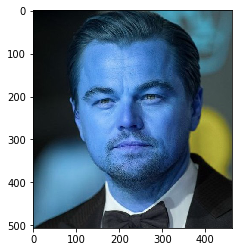

In [11]:
# Test for face_img_to_encoding
embedding = face_img_to_encoding("my_images/dicaprio.jpg", FRmodel)
img = cv2.imread("my_images/dicaprio.jpg")
#Visualize the image
plt.imshow(img)
#Visualize the embedding
print(embedding)

## Face Verification

Face Verification is a 1:1 matching problem given identity of a person program identifies if the picture of a person matches with identity

- verify() function below implements simple face-verification functionality

In [12]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    match -- True, if person(embedding) matches with the identity(embedding) .
    """
    
    # Encodings in the image. 
    encodings = face_img_to_encoding(image_path, FRmodel)
    
    #Loop inside encodings to obtain encoding of each person
    for encoding in encodings:
        # Step 2: Compute distance with identity's image 
        dist = np.linalg.norm(encoding - database[identity])
    
        # Step 3: Match if dist < 0.8
        if dist < 0.8:
            print(str(identity) + ", you are verified")
            match = True
        else:
            print("You're not " + str(identity) + "!!!")
            match = False
        
    return dist, match

## Let's see if we can verify Matt Damon

In [13]:
verify("my_images/dicaprio.jpg", "matt damon", database, FRmodel)

A face is located at pixel location Top: 142, Left: 82, Bottom: 409, Right: 349
You're not matt damon!!!


(0.9403599, False)

In [14]:
verify("my_images/mattDamon1.jpg", "matt damon", database, FRmodel)

A face is located at pixel location Top: 98, Left: 98, Bottom: 253, Right: 253
matt damon, you are verified


(0.74256897, True)

## Face Recognition

Identifies the person withou needing to provide an identity. This is a 1:K matching problem. 

Steps:
1. Compute the target encoding of the image from image_path
2. Find the encoding from the database that has smallest distance with the target encoding. 

In [42]:
def recognize(image_path, database, model):
    """
    Implements face recognition by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- Inception model instance in Keras
    
    Returns:
    identities -- list, containing names of the predicted people on the image_path image
    """
    
    ## Step 1: Compute the encodings
    encodings = face_img_to_encoding(image_path, model)
    
    # Initialize the lists for keeping track of people in the picture
    identities = []
    unknown_encodings = []
    
    # Loop over person encodings in the specific image
    for encoding in encodings:
        
        ## Step 2: Find the closest encoding ##
        
        # Initializing "min_dist" to a large value, say 100 
        min_dist = 100
    
        # Loop over the database dictionary's names and encodings.
        for (name, db_encodings) in database.items():
            
            for db_enc in db_encodings:
        
                # Compute L2 distance between the target "encoding" and the current "emb" from the database. 
                dist = np.linalg.norm(encoding - db_enc)

                # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. 
                if dist < min_dist:
                    min_dist = dist
                    identity = name
                
            if min_dist > 0.8:
                print("Not in the database.")
                #Add the encoding in the database for unknown encodings
                unknown_encodings.append(encoding)
                
            else:
                if identity not in identities and identity != "unknown":
                    print ("You're " + str(identity) + ", the distance is " + str(min_dist))
                    #Add the encoding to the known person's encoding list so that model can become more robust.
                    identities.append(identity)
                    face_encodings = database[str(identity)]
                    face_encodings.append(encoding)
                    database[str(identity)] = face_encodings
    
    for encoding in unknown_encodings:
        unknown = database["unknown"]
        unknown.append(encoding)
        database["unknown"] = unknown
        
    return identities

## Let's see if the database can recognize unseen picture of Matt Damon

In [44]:
recognize("my_images/mattDamon1.jpg", database, FRmodel)

A face is located at pixel location Top: 98, Left: 98, Bottom: 253, Right: 253
Not in the database.
Not in the database.
You're matt damon, the distance is 0.74256897


(0.7076221, ['matt damon'])

### End of The Recognition & Verification, Congratulations

Keep Learning...